# How to Tune Models like a Puppet-master Based on Confusion Matrix
## Learn to control model output based on what's important to the problem using a confusion matrix

![](./images/pixabay.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://pixabay.com/users/tskirde-3014515/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1594638'>Thomas Skirde</a>
        on 
        <a href='https://pixabay.com/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1594638'>Pixabay</a>
    </strong>
</figcaption>

### Setup

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["figure.figsize"] = [12, 9]
rcParams["figure.dpi"] = 300
rcParams["figure.autolayout"] = True
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15

warnings.filterwarnings("ignore")

### Introduction  TODO

Classification is a huge part of machine learning. Its benefits and applications are endless - ranging from detecting new asteroids and planets to identifying cancerous cells are all done using classification algorithms. 

The type of the problems classification solves is divided into two: unsupervised and supervised. Unsupervised models are called neural networks and they can be trained on unstructured data such as video, audio and images. In contrast, supervised models work with labeled, tabular data and is part of classic machine learning. The focus of this article is the latter, particularly, we will be exploring what all supervised classification problems have in common: *confusion matrices*.

### Developing a Classification Preprocessing Pipeline

A good model needs good data. So, it is important to process the available information as much as possible to achieve best model performance even before tuning it based on confusion matrices. 

A typical preprocessing workflow includes dealing with missing values, scaling/normalizing numeric features, encoding categorical variables and do all other feature engineering steps required. We will see an example of this in this section.

We will be predicting credit card approvals using the [Credit Card Approval Dataset](http://archive.ics.uci.edu/ml/datasets/credit+approval) from UCI Machine Learning Repository. Before banks can issue credit cards to new customers, there are many factors to consider: income levels, loan balances, individual's credit report, etc. This is often a difficult and mundane task, so nowadays banks use ML algorithms. Let's take a peek at the data:

In [18]:
import pandas as pd

df = pd.read_csv("data/cc_approvals.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Since it is private data, the feature names are left blank. Let's fix that first:

In [19]:
df.columns = ["feature_" + str(col) for col in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   690 non-null    object 
 1   feature_1   690 non-null    object 
 2   feature_2   690 non-null    float64
 3   feature_3   690 non-null    object 
 4   feature_4   690 non-null    object 
 5   feature_5   690 non-null    object 
 6   feature_6   690 non-null    object 
 7   feature_7   690 non-null    float64
 8   feature_8   690 non-null    object 
 9   feature_9   690 non-null    object 
 10  feature_10  690 non-null    int64  
 11  feature_11  690 non-null    object 
 12  feature_12  690 non-null    object 
 13  feature_13  690 non-null    object 
 14  feature_14  690 non-null    int64  
 15  feature_15  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


The dataset contains both numeric and categorical features. The missing values in this dataset are encoded with question marks (?). We will replace them with `NaN`s:

In [20]:
import numpy as np

df = df.replace("?", np.nan).copy()

df.isnull().sum()

feature_0     12
feature_1     12
feature_2      0
feature_3      6
feature_4      6
feature_5      9
feature_6      9
feature_7      0
feature_8      0
feature_9      0
feature_10     0
feature_11     0
feature_12     0
feature_13    13
feature_14     0
feature_15     0
dtype: int64

Features 0, 1, 3, 4, 5, 6 and 13 contain missing values. Inspecting the data, we may guess that feature 13 contains zipcodes, so we can drop it. And for others, since they make up less than the 5% of the dataset, we can drop rows with nulls:

In [21]:
# Drop zipcode col
df.drop("feature_15", axis=1, inplace=True)

# Drop rows with NaNs
df.dropna(how="any", inplace=True)

df.shape

(653, 15)

Let's focus on numeric values now. Specifically, we will look at their distributions:

In [22]:
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
feature_2,653.0,4.830,5.027,0.0,1.040,2.835,7.500,28.0
feature_7,653.0,2.244,3.371,0.0,0.165,1.000,2.625,28.5
feature_10,653.0,2.502,4.968,0.0,0.000,0.000,3.000,67.0
feature_14,653.0,1013.761,5253.279,0.0,0.000,5.000,400.000,100000.0


All features have a minimum of 0 but they are all on different scales. This means we have to use some type of normalization and we will see what kind by exploring these features visually:

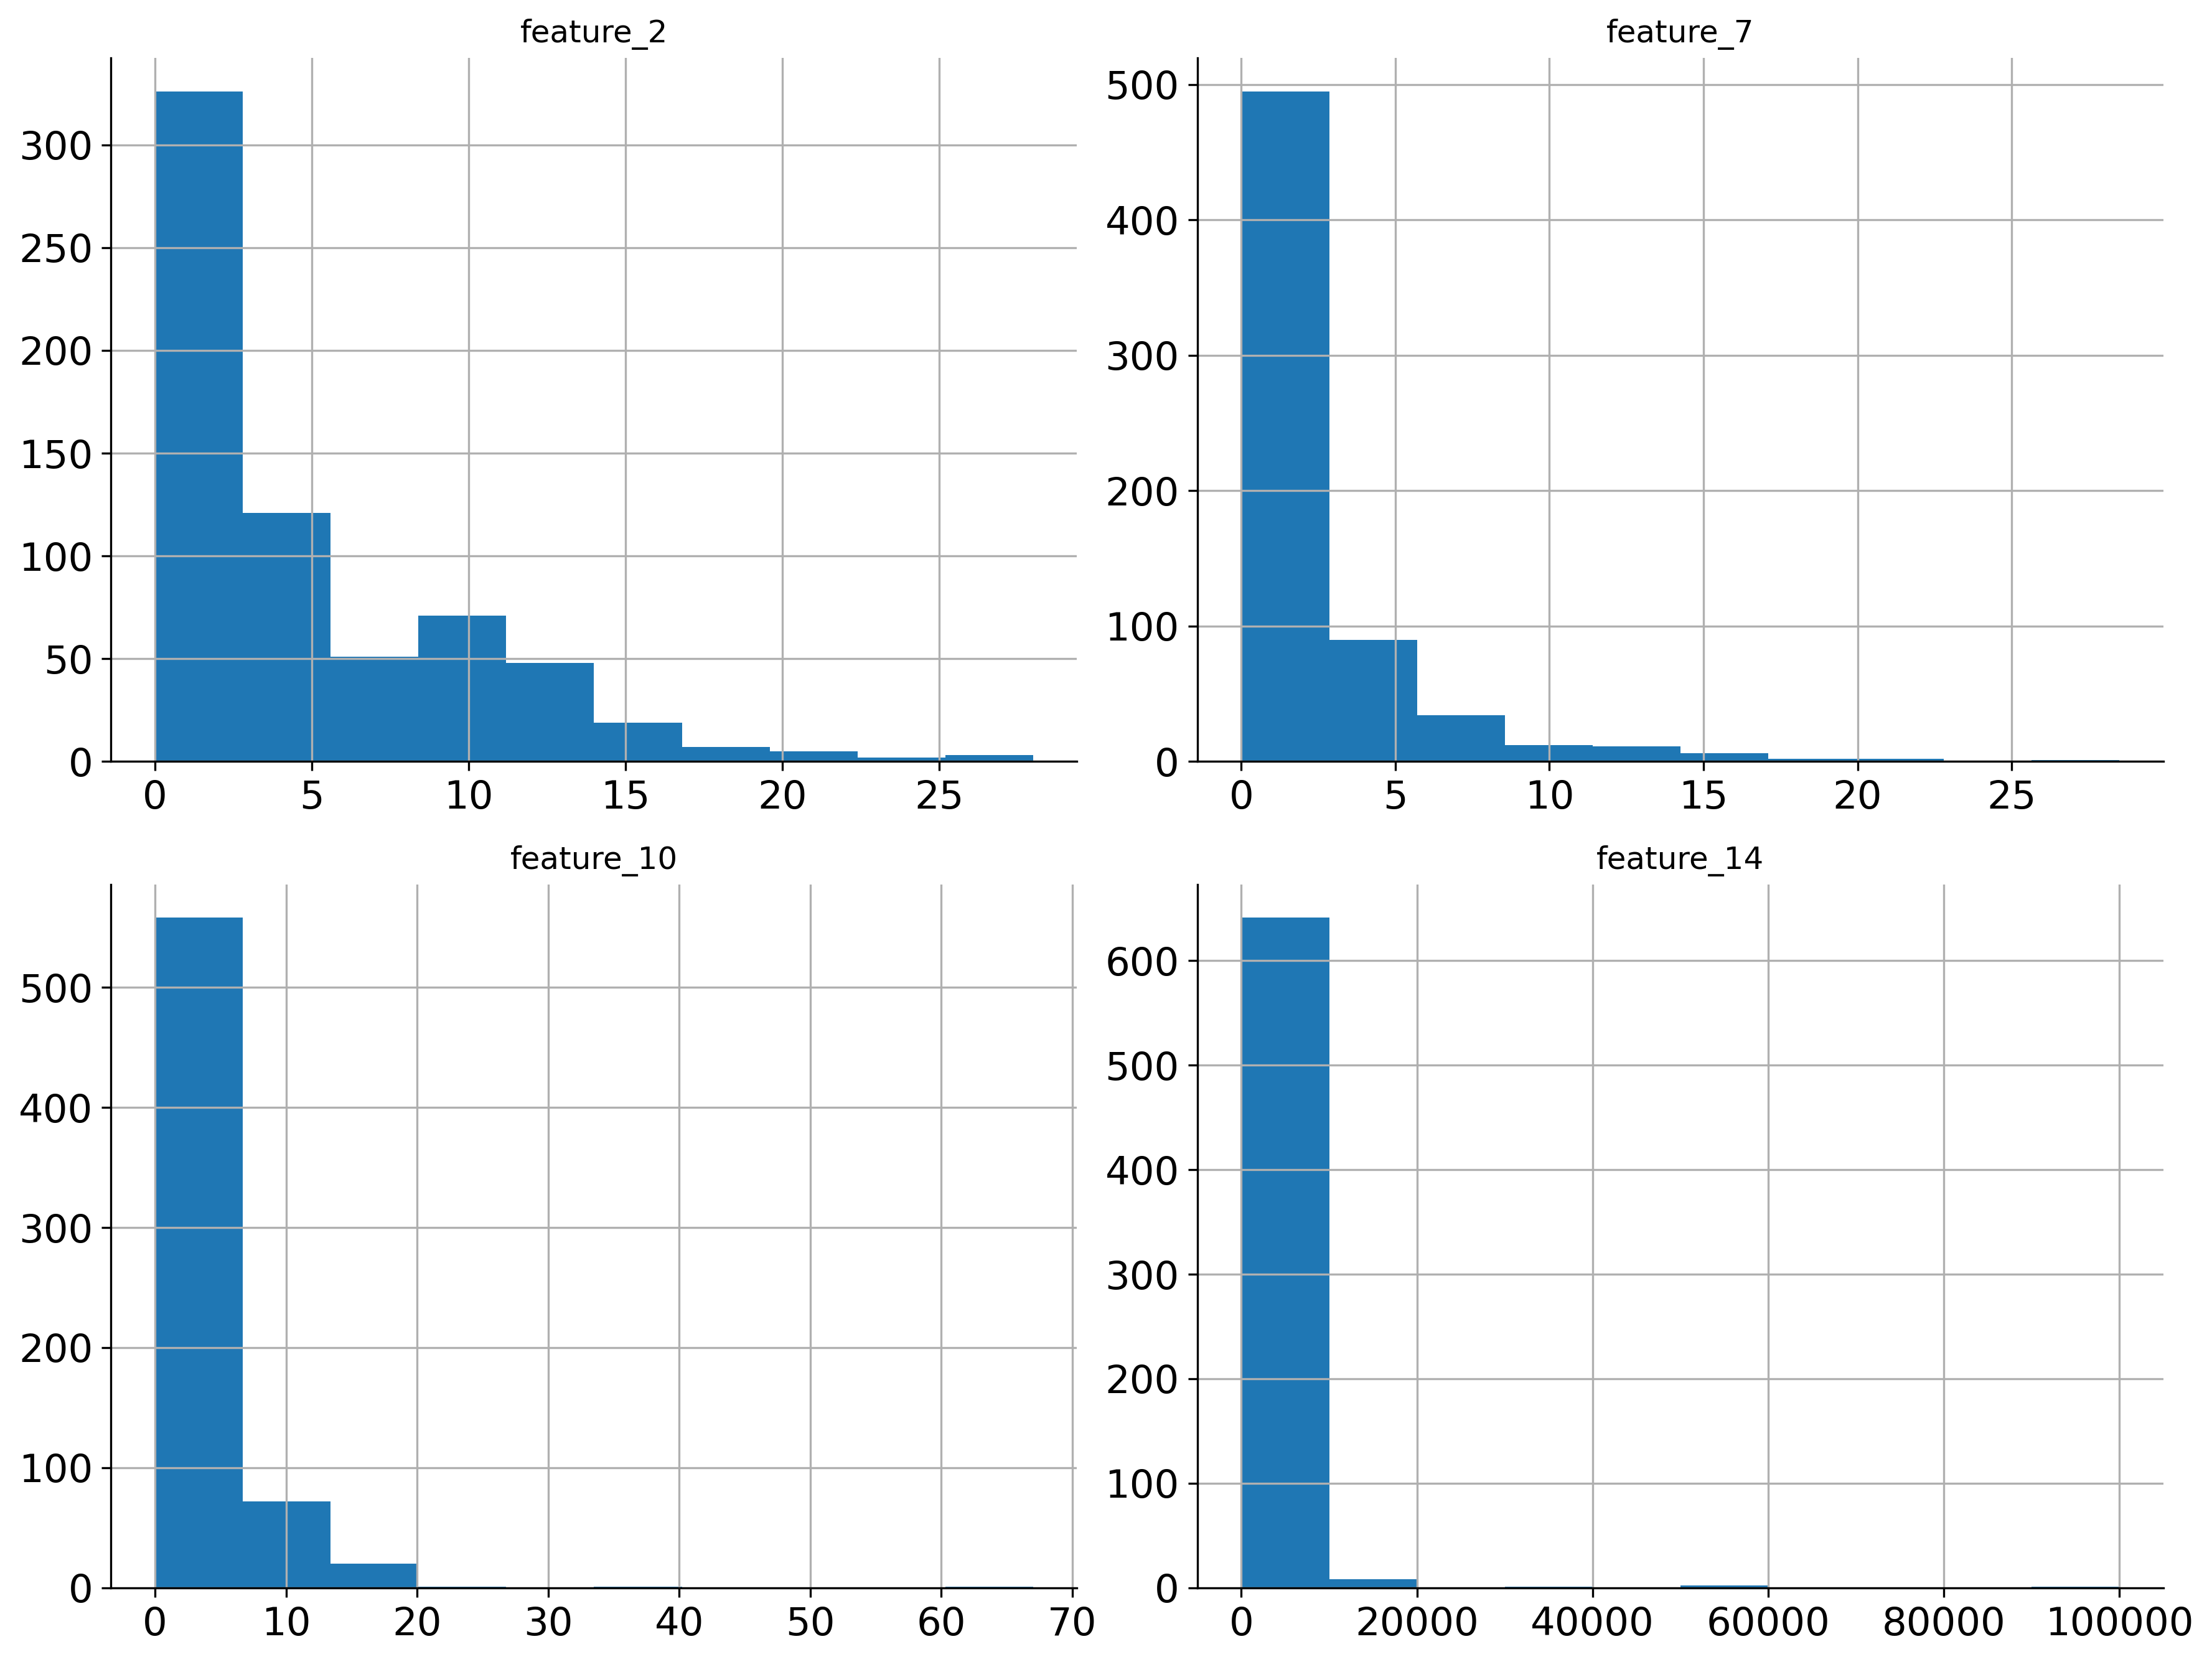

In [23]:
import seaborn as sns

df.hist();

Features have skewed distributions which means, we will perform non-linear transform such as `PowerTransformer` (uses logarithms under the hood):

In [25]:
# Store the cols to be log transformed
to_log = df.select_dtypes(include="number").columns.to_list()
to_log

['feature_2', 'feature_7', 'feature_10', 'feature_14']

To encode categorical features, we will use a `OneHotEncoder`. Before isolating the columns to be used in encoding, let's separate the data into feature and target arrays:

In [11]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]  # the last column is the target

Now, isolate the categorical columns to be OH encoded:

In [27]:
categorical_cols = X.select_dtypes(include="object").columns.to_list()

Finally, we will build the preprocessing pipeline:

> If you are not familiar with Sklearn pipelines and column transformers, I recommend reading this post:
https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.tree import ExtraTreeClassifier

# Create a col_transformer object
col_transformer = ColumnTransformer(
    transformers=[
        ("log", PowerTransformer(), to_log),
        (
            "oh_encode",
            OneHotEncoder(sparse=False, handle_unknown="ignore"),
            categorical_cols,
        ),
    ]
)

# Combine into a final pipeline
pipeline = Pipeline(
    steps=[("preprocess", col_transformer), ("base_model", ExtraTreeClassifier())]
)

# Encode the target
y = LabelEncoder().fit_transform(y)